In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

import timeit

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestClassifier

from scipy import interp
from imblearn.under_sampling import RandomUnderSampler

In [2]:
#set random seed
rs=4

In [3]:
#read data
full_data=pd.read_csv('part3_data.csv')

In [4]:
#Dropping columns (id is arbitrary, address codes must be sensibly preprocessed to be useful, make and model are categorical variables with many levels and the information they contain is reflected inb other columns, presence of second driver is also contained elsewhere
data=full_data.drop(columns=['id_policy', 'commune_code', 'canton_code', 'city_district_code', 'regional_department_code', 'pol_insee_code', 'vh_make', 'vh_model', 'drv_drv2'])

In [5]:
#Change to number of number of payments per year
values_pol_pay_freq={'Yearly':1, 'Monthly':12, 'Biannual':0.5, 'Quarterly':4}
data.pol_pay_freq=data.pol_pay_freq.replace(values_pol_pay_freq)

In [6]:
#categorical columns
cat_cols = ['pol_coverage', 'pol_payd', 'pol_usage', 'drv_sex1', 'vh_fuel', 'vh_type']

In [7]:
#one-hot encoding
data=pd.get_dummies(data, prefix=cat_cols, columns=cat_cols, dummy_na=False)

In [8]:
#one hot encoding, also encoding if the value is missing which corresponds to values of drv_drv2
data=pd.get_dummies(data, prefix=['drv_sex2'], columns=['drv_sex2'], dummy_na=True)

In [9]:
#remove remove with missing values (300 of them, can afford that)
data.dropna(inplace=True)

Imbalanced data.

In [10]:
data.made_claim.value_counts()

0    71794
1     7231
Name: made_claim, dtype: int64

Dropping claim amount, but can possibly be used as a richer signal for some later models.

In [11]:
data=data.drop(columns='claim_amount')

Separate predictors from labels.

In [12]:
X_df, Y_df = data.loc[:, data.columns!= 'made_claim'], data.loc[:, data.columns == 'made_claim']
X, Y = X_df.values, Y_df.values

Function which takes sklearn classifier and performs n-fold cross-validation, plotting ROC for each fold and calculating AUC. Can optionally undersample data, but for this it requires imblearn. 

In [13]:
rus = RandomUnderSampler(random_state=rs)
summary_roc={}

def cv_mean_roc(X, y, classifier, name, undersample_data=False, n_splits=5):
      
    cv = StratifiedKFold(n_splits=n_splits)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    


    i = 0
    start_time = timeit.default_timer()
    plt.figure(figsize=(6,6))
    for train, test in cv.split(X, y):
        if undersample_data: #need RandomUnderSampler from imblearn to work
            X_b, y_b=rus.fit_resample(X[train], y[train])
            probas_ = classifier.fit(X_b, y_b).predict_proba(X[test])
        else:
            probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    elapsed = timeit.default_timer() - start_time
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name+' ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    summary_roc[name]=(mean_fpr, mean_tpr, mean_auc, std_auc, elapsed)

/Users/aleksander/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aleksander/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aleksander/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aleksander/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was 

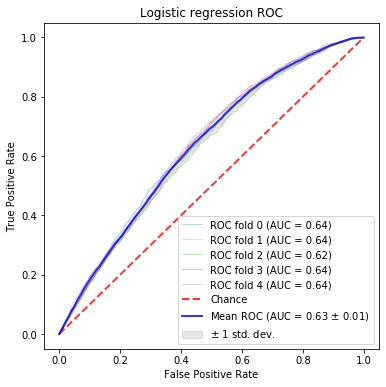

In [14]:
logreg=LogisticRegression(class_weight='balanced', random_state=rs, solver='lbfgs', max_iter=10000)

cv_mean_roc(X, Y, logreg, 'Logistic regression', n_splits=5)

In [15]:
#Split to train test
X_df_train, X_df_test, Y_df_train, Y_df_test = train_test_split(X_df, Y_df, test_size=0.1, random_state=rs)
X_train, X_test, Y_train, Y_test = X_df_train.values, X_df_test.values, Y_df_train.values.ravel(), Y_df_test.values.ravel()
X_b, Y_b = rus.fit_resample(X_train, Y_train)

In [16]:
rf=RandomForestClassifier(n_estimators=8192, random_state=rs, verbose=1, n_jobs=-1)
rf.fit(X_b, Y_b)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 8192 out of 8192 | elapsed:   42.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8192,
                       n_jobs=-1, oob_score=False, random_state=4, verbose=1,
                       warm_start=False)

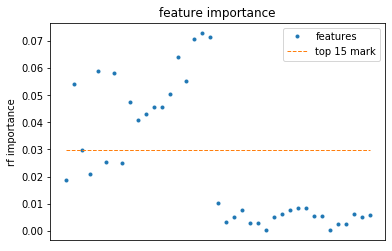

In [17]:
importances=rf.feature_importances_
select_n=15
fig,ax = plt.subplots()
importances.argsort()[-select_n:][::-1]
ax.plot(importances,'.',label='features')
ax.plot(0*importances+importances[importances.argsort()[-select_n]],ls='--',label='top '+str(select_n)+' mark',lw=1)
ax.set_xticklabels([])
ax.set_xticks([])
plt.title('feature importance')
plt.legend(loc='best')
plt.ylabel('rf importance')
plt.show()

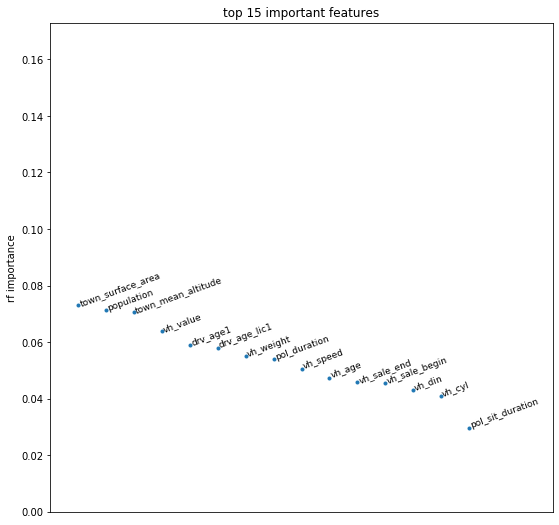

In [18]:
fig,ax = plt.subplots(figsize=(9,9))
labels=list(data.loc[:, data.columns != 'made_claim'].columns[importances.argsort()[-select_n:][::-1]])
ax.plot(importances[importances.argsort()[-select_n:][::-1]],'.')

for i in range(len(labels)):
    plt.annotate(labels[i],(i,importances[importances.argsort()[-select_n:][::-1]][i]),fontsize=9,rotation=20)
plt.title('top '+str(select_n)+' important features')
ax.set_xticklabels([])
ax.set_xticks([])
plt.ylabel('rf importance')
plt.ylim(0,importances[importances.argsort()[-select_n:][::-1]][0]+0.1)
plt.xlim(-1,select_n+2)
plt.show()

In [19]:
X_imp=data.loc[:,data.loc[:, data.columns != 'made_claim'].columns[importances.argsort()[-select_n:][::-1]]]

/Users/aleksander/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aleksander/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aleksander/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aleksander/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was 

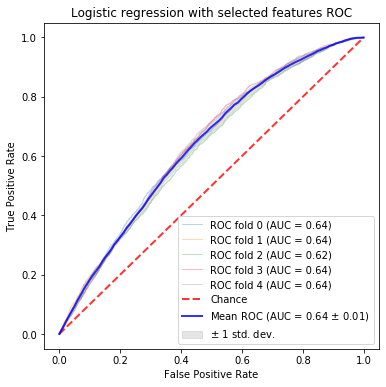

In [20]:
cv_mean_roc(X_imp.values, Y, logreg, 'Logistic regression with selected features', n_splits=5)

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
cont_cols = ['pol_bonus','pol_duration','pol_sit_duration','pol_pay_freq',
                           'drv_age1','drv_age2','drv_age_lic1','drv_age_lic2','vh_age',
                           'vh_cyl','vh_din','vh_sale_begin','vh_sale_end','vh_speed',
                           'vh_value','vh_weight','town_mean_altitude','town_surface_area','population']

In [23]:
def apply_pca(X_df_train, X_df_test, PCA, cont_cols, include_categorical=True):
    ss = StandardScaler()
    
    X_train_cont = X_df_train.loc[:, cont_cols].values
    X_train_cat = X_df_train.drop(columns=cont_cols).values
    X_test_cont = X_df_test.loc[:, cont_cols].values
    X_test_cat = X_df_test.drop(columns=cont_cols).values
    
    if include_categorical:
        X_train_pca = np.concatenate([pca.fit_transform(ss.fit_transform(X_train_cont)), X_train_cat], axis=1)
        X_test_pca = np.concatenate([pca.transform(ss.transform(X_test_cont)), X_test_cat], axis=1)
    else:
        X_train_pca = pca.fit_transform(ss.fit_transform(X_train_cont))
        X_test_pca = pca.transform(ss.transform(X_test_cont))
        
    return X_train_pca, X_test_pca

In [24]:
pca = PCA(n_components=4, random_state=rs)
X_train_pca, X_test_pca = apply_pca(X_df_train, X_df_test, pca, cont_cols, include_categorical=True)

In [25]:
logreg.fit(X_train_pca, Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=4, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

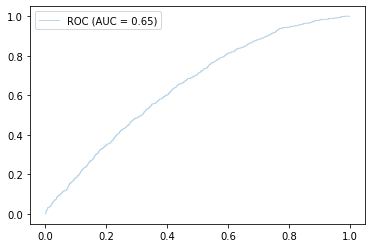

In [26]:
#Plot ROC
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test_pca)[:, 1])
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC (AUC = %0.2f)' % auc(fpr, tpr))
plt.legend(loc='best')
plt.show()